# Análisis de Tópicos en las Mañaneras de AMLO

## Introducción

El análisis de tópicos es una técnica del procesamiento de lenguaje natural (NLP) que permite identificar patrones semánticos latentes en grandes volúmenes de texto. A través de métodos no supervisados como el Análisis Semántico Latente (LSA), es posible reducir la dimensionalidad de los datos y extraer representaciones significativas que revelan los temas más relevantes abordados en un conjunto de documentos.

En este trabajo, se analizará el contenido de las conferencias matutinas del presidente de México, Andrés Manuel López Obrador, comúnmente conocidas como "mañaneras". Estas conferencias, realizadas casi a diario, ofrecen una gran fuente de texto político y social que puede ser estudiada desde una perspectiva computacional.

## Objetivo del problema

Aplicar técnicas de modelado de tópicos sobre las transcripciones semanales de las conferencias matutinas del presidente AMLO, utilizando una representación documento-término (TF-IDF) y el método de descomposición SVD (TruncatedSVD). El objetivo es identificar automáticamente los principales temas abordados a lo largo del tiempo, entre los años 2019 y 2023, y obtener una representación densa y de baja dimensión que capture la estructura semántica subyacente del discurso presidencial.


In [20]:
import os
import glob
from datetime import datetime

import numpy as np
import pandas as pd

from collections import Counter

from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Lectura de las mañaneras de AMLO (2018-2023)

Se recorre la estructura de directorios organizada por año, mes y día, correspondiente a las conferencias matutinas del presidente Andrés Manuel López Obrador, almacenadas en la ruta base `../conferencias_matutinas_amlo`. El objetivo es extraer y agrupar las transcripciones del presidente por semana calendario.

### Descripción general del procedimiento

1. **Recorrido por los años**  
   Se itera desde 2018 hasta 2023. Para cada año, se verifica la existencia del directorio correspondiente.

2. **Exploración mensual y diaria**  
   Dentro de cada año, se recorren los subdirectorios correspondientes a los meses y, posteriormente, a los días.

3. **Búsqueda del archivo CSV del presidente**  
   En cada día, se busca el archivo CSV correspondiente al presidente. Se consideran posibles variaciones en la acentuación del apellido (`LOPEZ`, `LÓPEZ`, `LOP[EÉ]Z`) para garantizar una búsqueda robusta.

4. **Extracción del texto y agrupamiento semanal**  
   Una vez localizado el archivo, se concatena todo el texto de la columna `"Texto"`, se determina la fecha del discurso y se calcula el número de semana correspondiente (`ISO week number`). Luego, se agrupa la transcripción por semana en el diccionario `president_transcriptions_by_week`.

### Notas importantes

- Se omiten directorios que no existen o que no corresponden a carpetas válidas.
- La estructura de carpetas esperada es:  
  `../conferencias_matutinas_amlo/AÑO/MES/DIA/csv_por_participante/PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR.csv`
- El agrupamiento semanal permite realizar análisis temporales de contenido, por ejemplo, temas frecuentes por semana o evolución del discurso.

In [21]:
# Directorio base donde se encuentran los archivos de las conferencias matutinas
base_dir = "../conferencias_matutinas_amlo"

# Diccionario para almacenar las transcripciones del presidente por semana
president_transcriptions_by_week = {}

# Recorrer los años 2018 a 2023
for year in range(2018, 2024):
    year_dir = os.path.join(base_dir, str(year))
    if not os.path.exists(year_dir):
        continue
    
    # Recorrer los meses dentro de cada año
    for month_dir in os.listdir(year_dir):
        month_path = os.path.join(year_dir, month_dir)
        
        if not os.path.isdir(month_path):
            continue
        
        # Recorrer los días dentro de cada mes
        for day_dir in os.listdir(month_path):
            day_path = os.path.join(month_path, day_dir)
            if not os.path.isdir(day_path):
                continue
            
            # Encontrar el archivo CSV del presidente dentro de cada día
            # Ruta base
            president_base_path = os.path.join(day_path, "csv_por_participante", "PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR.csv")
            
            # Buscar variantes con/sin acento
            possible_files = glob.glob(president_base_path.replace("LOPEZ", "LÓPEZ").replace("LÓPEZ", "LOP[EÉ]Z"))

            if possible_files:
                president_csv_path = possible_files[0]  # Tomamos el primer archivo que coincida

            if os.path.exists(president_csv_path):
                # Leer el archivo CSV
                df = pd.read_csv(president_csv_path)
                # Obtener el texto
                transcriptions = df['Texto'].str.cat(sep=' ')
                # Obtener la fecha del día
                date_str = f"{df['Anio'].iloc[0]}-{df['Mes'].iloc[0]}-{df['Dia'].iloc[0]}"
                date_obj = datetime.strptime(date_str, "%Y-%m-%d")
                # Obtener el número de semana en el año
                week_number = date_obj.isocalendar()[1]
                # Agrupar por número de semana
                week_key = f"{year}-Week-{week_number}"
                # Agregar las transcripciones al diccionario por semana
                if week_key in president_transcriptions_by_week:
                    president_transcriptions_by_week[week_key] += ' ' + transcriptions
                else:
                    president_transcriptions_by_week[week_key] = transcriptions

## Preprocesamiento de las conferencias semanales

Una vez que se han leído los archivos de las conferencias matutinas del presidente y agrupado el contenido por semana, se construye un `DataFrame` con la estructura:

- `semana`: clave compuesta con el año y número de semana (`AAAA-Week-NN`).
- `texto`: transcripción concatenada de todas las intervenciones del presidente durante esa semana.

Posteriormente, los datos se ordenan cronológicamente por año y número de semana, y se almacenan en un archivo `Excel` llamado `conferencias_original.xlsx`.

In [22]:
# Preparar datos
df_weeks = pd.DataFrame(list(president_transcriptions_by_week.items()), columns=['semana', 'texto'])
df_weeks[['anio', 'semana_num']] = df_weeks['semana'].str.extract(r'(\d+)-Week-(\d+)').astype(int)
df_weeks = df_weeks.sort_values(by=['anio', 'semana_num'])

# Guardar en un archivo Excel
df_weeks.to_excel("./scripts/conferencias_original.xlsx", index=False)

## Script `limpieza.py`: Limpieza usando cómputo paralelo

El archivo `limpieza.py` tiene como objetivo aplicar una limpieza profunda y sistemática a los textos de las conferencias matutinas presidenciales, previamente agrupados por semana. Esta limpieza es un paso crucial para preparar los datos antes de llevar a cabo tareas de análisis semántico, como el modelado de tópicos o la reducción de dimensionalidad.

### ¿Qué hace este script?

1. **Carga el archivo `conferencias_original.xlsx`**, que contiene las transcripciones semanales originales.

2. **Define una función de limpieza personalizada**, `limpiar_texto`, que realiza:
   - **Normalización básica**: conversión a minúsculas, eliminación de acentos y caracteres no alfabéticos.
   - **Tokenización y filtrado** con `spaCy`: se eliminan palabras vacías (*stopwords*) y conectores/muletillas típicas del lenguaje oral.
   - **Reducción de redundancia léxica** usando fuzzy matching, para eliminar palabras muy similares.

3. **Ejecuta la limpieza en paralelo** sobre todos los textos utilizando `multiprocessing`, lo que permite aprovechar todos los núcleos del procesador y **acelerar considerablemente el tiempo de ejecución**, especialmente útil cuando se trabaja con cientos de documentos.

4. **Guarda el resultado en un nuevo archivo `conferencias_limpias.xlsx`**, que contiene una nueva columna con los textos ya preprocesados.

### Limpieza paralela con `multiprocessing`

Para evitar procesar los textos secuencialmente (lo cual sería muy lento), se implementa la función `procesar_en_paralelo_tqdm`, que distribuye el trabajo entre todos los núcleos disponibles del sistema.


In [25]:
!python scripts/limpieza.py

100%|█████████████████████████████████████████| 261/261 [01:31<00:00,  2.87it/s]


In [27]:
df_limpio = pd.read_excel("./scripts/conferencias_limpias.xlsx")
# --- 5. Contar el numero de palabras por documento
df_limpio['num_palabras'] = df_limpio['texto_limpio'].str.split().str.len()

df_limpio.head()

semana                                              texto  anio  \
0  2018-Week-50   Buenas tardes. Sí. Es que son buenos días, pe...  2018   
1  2018-Week-52  : Buenos días. El día de hoy vamos a presentar...  2018   
2   2019-Week-1  : El día de hoy vamos a tratar, como lo mencio...  2019   
3   2019-Week-2  : Buenos días. Estamos terminando el periodo c...  2019   
4   2019-Week-3  : Buenos días. Vamos a informarles. El día de ...  2019   

   semana_num                                       texto_limpio  num_palabras  
0          50  tardes llegue estabamos tratando temas importa...           792  
1          52  tratar mencionamos temas informarles estadisti...           984  
2           1  presentar plan conjunto gobierno republica com...           913  
3           2  terminando periodo conocido guadalupereyes con...           980  
4           3  continuamos trabajando respuesta solucion prob...           965

In [28]:
# Frecuencia general
all_tokens = df_limpio['texto_limpio'].str.split().sum()
frecuencias = Counter(all_tokens)

print("Top 50 palabras más frecuentes:")
frecuencias.most_common(10)

Top 50 palabras más frecuentes:


[('mexico', 261),
 ('caso', 260),
 ('gente', 258),
 ('informacion', 255),
 ('anos', 250),
 ('millones', 250),
 ('seguir', 249),
 ('vida', 247),
 ('cabo', 246),
 ('corrupcion', 245)]

### Extracción y visualización de tópicos con TF-IDF y SVD

En esta sección se realiza el modelado de tópicos a partir de las transcripciones limpias utilizando una combinación de **vectorización TF-IDF** y mediante la **descomposición SVD (Singular Value Decomposition)**.

#### Vectorización con TF-IDF

Se emplea el transformador `TfidfVectorizer` para convertir el corpus textual en una matriz numérica, donde cada fila representa un documento y cada columna un término (ya sea palabra, bigrama o trigrama). La ponderación TF-IDF permite capturar la **importancia relativa** de cada término en el contexto de un documento y del corpus completo, penalizando las palabras demasiado frecuentes.

In [29]:
# --- Vectorización TF-IDF
vectorizer = TfidfVectorizer(
    max_features=800,       # Se conservan los 800 términos más informativos
    min_df=0.01,            # Se excluyen términos presentes en menos del 1% de los documentos
    max_df=0.70,            # Se excluyen términos demasiado comunes
    ngram_range=(1, 3),     # Se incluyen unigramas, bigramas y trigramas
)

X_tfidf = vectorizer.fit_transform(df_limpio['texto_limpio'])
terms = vectorizer.get_feature_names_out()

#### Modelado de tópicos con SVD

A partir de la matriz TF-IDF se aplica **Truncated SVD** para descomponer la matriz original y reducir su dimensionalidad, extrayendo componentes latentes que representan temas.

- Una matriz **documento-tópico** que representa cada documento en un espacio reducido de tópicos latentes.
- Una matriz **tópico-palabra** que indica la importancia de cada término dentro de cada tópico.

SVD es útil para descubrir estructuras semánticas latentes y reducir el ruido en datos textuales, facilitando la interpretación y visualización de los temas.

In [30]:
k = 15  # número de tópicos
svd = TruncatedSVD(n_components=k, random_state=42)
X_svd = svd.fit_transform(X_tfidf)  # Matriz documento-tópico
components = svd.components_        # Matriz tópico-palabra

Para determinar el número adecuado de tópicos `k`, se realizaron pruebas variando su valor y analizando las **nubes de palabras (wordclouds)** generadas para cada conjunto de tópicos. Esto permitió evaluar la coherencia y claridad semántica de los temas extraídos.

Finalmente, se eligió `k = 15` como el número óptimo de tópicos, pues ofreció un balance adecuado entre detalle y generalización de los temas presentes en los documentos.


#### Visualización de tópicos con WordCloud

Para interpretar los tópicos, se utiliza la matriz `svd.components_`, que contiene los pesos de cada término en cada componente (tópico). Se visualizan como **nubes de palabras**, donde el tamaño de cada término indica su importancia dentro del tópico correspondiente.

Cada gráfico generado muestra un tópico, facilitando su interpretación cualitativa.


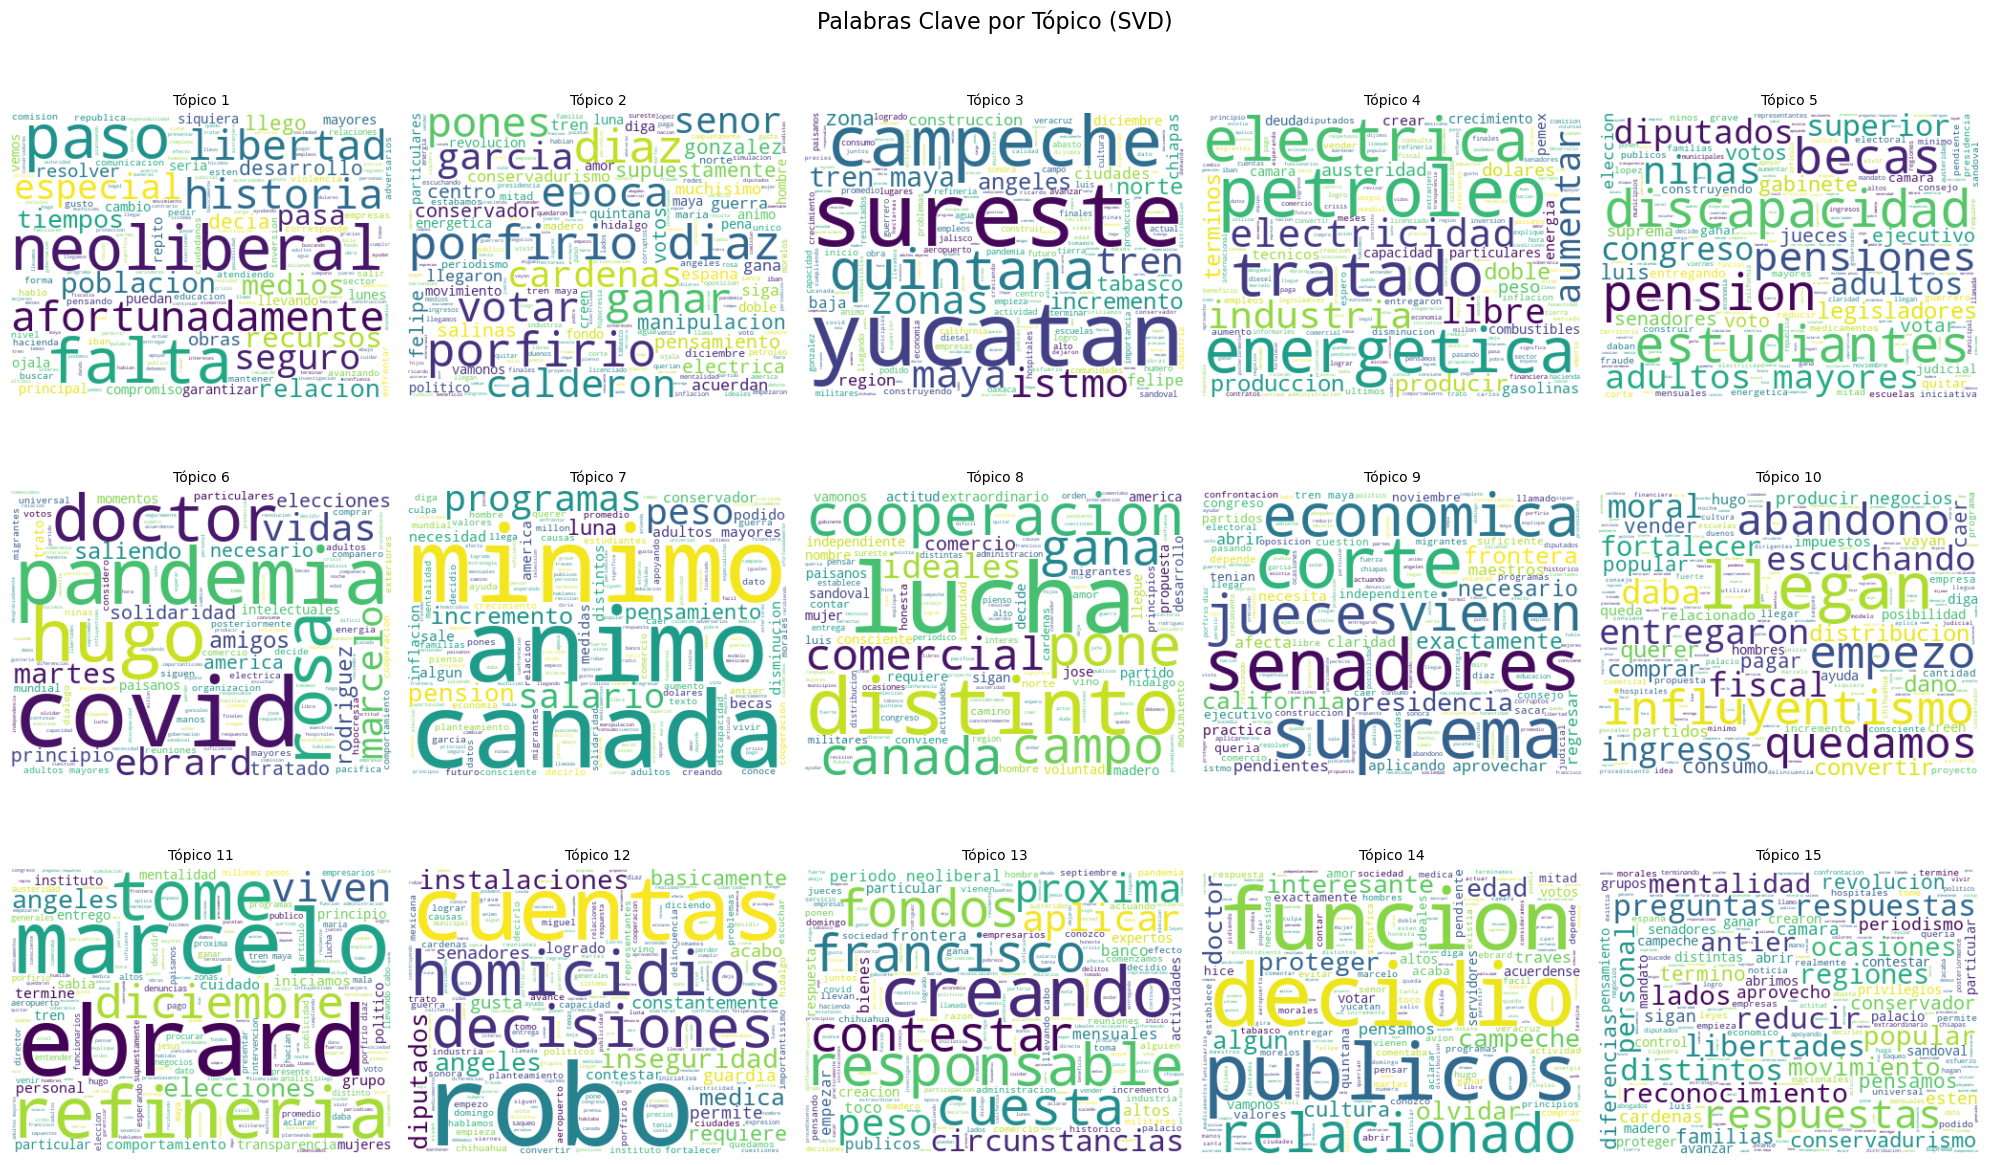

In [31]:
# --- Visualizar los tópicos con WordCloud
filas, columnas = 3, 5
fig, axes = plt.subplots(filas, columnas, figsize=(20, 12))

# Aplanar el array de ejes para facilitar la iteración
axes = axes.flatten()

# Generar y mostrar cada WordCloud en su subgráfico
for i, componente in enumerate(components[:15]):  # Asegúrate de tomar solo 15 componentes
    pesos = dict(zip(terms, componente))
    wc = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(pesos)
    
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f'Tópico {i + 1}', fontsize=10)
    axes[i].axis('off')

# Ajustar espacios y título general
plt.tight_layout()
plt.suptitle('Palabras Clave por Tópico (SVD)', fontsize=16, y=1.02)
plt.show()

In [32]:
nombre_topicos_svd = [
    "critíca al neoliberalismo", # 1 
    "fraude electoral", # 2
    "tren maya", # 3
    "reforma energética", # 4
    "programas sociales y pensiones", # 5
    "pandemia", # 6
    "economía y salario mínimo", # 7
    "relaciones internacionales y migración ", # 8
    "poder judicial y política institucional", # 9
    "corrupción", # 10
    "seguridad y delincuencia", # 11
    "explotación y saqueo del estado", # 12
    "privatización y salud pública", # 13
    "opinión pública", # 14
    "gestión del gobierno", # 15
]

In [33]:
# Obtener el tópico dominante para cada documento (conferencia)
topic_assignments = np.argmax(X_svd, axis=1)  # Índice del tópico con mayor score

df_limpio['topico_asignado'] = [nombre_topicos_svd[i] for i in topic_assignments]

# Ver distribución de tópicos
print(df_limpio['topico_asignado'].value_counts())

topico_asignado
critíca al neoliberalismo    261
Name: count, dtype: int64


## Asignación de tópicos y distribución temática

Una vez generadas las nubes de palabras para cada uno de los 15 componentes latentes, **asignamos manualmente un nombre representativo a cada tópico** de acuerdo con las palabras más relevantes.

### Tabla de asignación de nombres a los tópicos extraídos por SVD

| Número de Tópico | Nombre del Tópico                                |
|------------------|--------------------------------------------------|
| 1                | crítica al neoliberalismo                        |
| 2                | fraude electoral                                 |
| 3                | tren maya                                        |
| 4                | reforma energética                               |
| 5                | programas sociales y pensiones                   |
| 6                | pandemia                                         |
| 7                | economía y salario mínimo                        |
| 8                | relaciones internacionales y migración           |
| 9                | poder judicial y política institucional          |
| 10               | corrupción                                       |
| 11               | seguridad y delincuencia                         |
| 12               | explotación y saqueo del estado                  |
| 13               | privatización y salud pública                    |
| 14               | opinión pública                                  |
| 15               | gestión del gobierno                             |

---

## Asignación de tópicos a los documentos

Una vez obtenidas las representaciones reducidas de los documentos en el espacio latente de SVD, se asignó a cada semana su **tópico dominante**, es decir, aquel componente con mayor peso para ese documento.

Sin embargo, se observó que **todos los documentos fueron asignados al mismo tópico** (tópico 1: *crítica al neoliberalismo*). Esto sugiere que:

- La variabilidad semántica entre documentos no fue capturada eficazmente por el modelo.
- La calidad y diversidad del corpus tras la limpieza limita el valor informativo.
- La dominancia de un único tema en los discursos semanales podría estar ocultando otras dimensiones semánticas más sutiles.

/Users/lucianoandresjuarezlopez/anaconda3/envs/ciencia_datos_proyecto/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



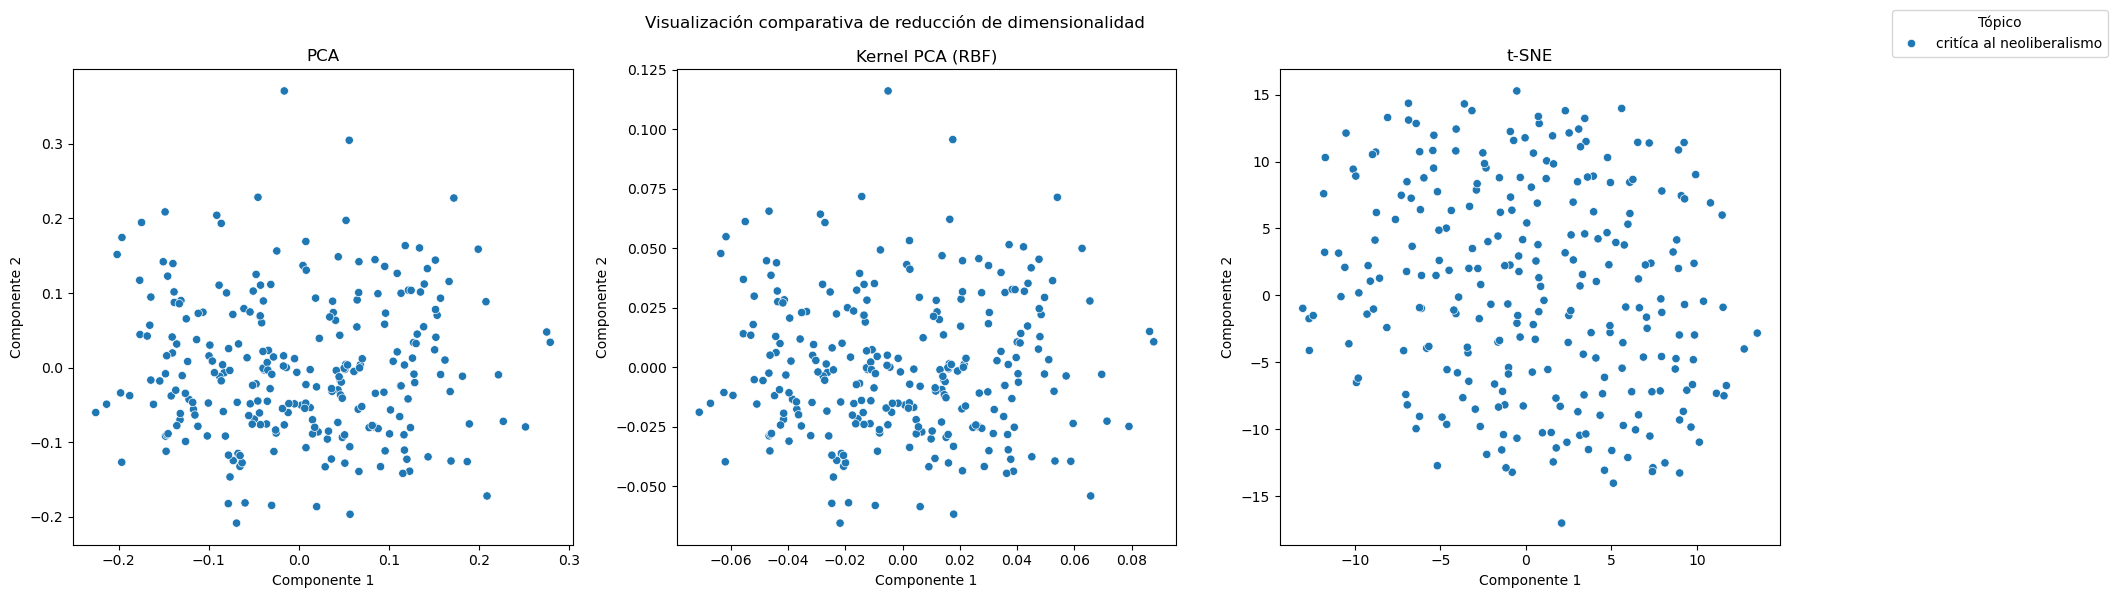

In [34]:
# --- Reducción de dimensionalidad ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_svd)

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.05)
X_kpca = kpca.fit_transform(X_svd)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_svd)

# --- Visualización conjunta ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PCA
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df_limpio['topico_asignado'],
    palette='tab10',
    ax=axes[0], legend=False
)
axes[0].set_title('PCA')
axes[0].set_xlabel('Componente 1')
axes[0].set_ylabel('Componente 2')

# Kernel PCA
sns.scatterplot(
    x=X_kpca[:, 0], y=X_kpca[:, 1],
    hue=df_limpio['topico_asignado'],
    palette='tab10',
    ax=axes[1], legend=False
)
axes[1].set_title('Kernel PCA (RBF)')
axes[1].set_xlabel('Componente 1')
axes[1].set_ylabel('Componente 2')

# t-SNE
sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=df_limpio['topico_asignado'],
    palette='tab10',
    ax=axes[2]
)
axes[2].set_title('t-SNE')
axes[2].set_xlabel('Componente 1')
axes[2].set_ylabel('Componente 2')

# Leyenda única
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, title='Tópico', bbox_to_anchor=(1.05, 1), loc='upper left')

axes[2].legend_.remove()

plt.suptitle('Visualización comparativa de reducción de dimensionalidad')
plt.tight_layout()
plt.show()


### Hallazgos observados en las visualizaciones

Aunque se aplicaron técnicas de reducción de dimensionalidad como **PCA**, **Kernel PCA** y **t-SNE** con el objetivo de visualizar posibles agrupamientos temáticos, el hecho de que todos los documentos caigan en el mismo tópico dominante **limita el valor informativo de estas visualizaciones**.

### Extracción y visualización de tópicos con TF-IDF y NMF

En esta sección se lleva a cabo el modelado de tópicos a partir de las transcripciones limpias utilizando una combinación de **vectorización TF-IDF** y **factorización no-negativa de matrices (NMF)**.

#### Vectorización con TF-IDF

Se emplea el transformador `TfidfVectorizer` para convertir el corpus textual en una matriz numérica, donde cada fila representa un documento y cada columna un término (ya sea palabra, bigrama o trigrama). La ponderación TF-IDF permite capturar la **importancia relativa** de cada término en el contexto de un documento y del corpus completo, penalizando las palabras demasiado frecuentes.

In [35]:
# --- Vectorización TF-IDF
vectorizer = TfidfVectorizer(
    max_features=800,  # más términos útiles
    min_df=0.01,          # al menos en 10% de los documentos
    max_df=0.90,          # no más del 90% de los documentos
    ngram_range=(1, 3), # incluye trigramas
)

X_tfidf = vectorizer.fit_transform(df_limpio['texto_limpio'])

#### Modelado de tópicos con NMF

A partir de la matriz TF-IDF se aplica el modelo NMF para descomponer la matriz original en dos componentes principales:

- Una matriz **documento-tópico** que describe la distribución de temas en cada documento.
- Una matriz **tópico-palabra** que define los términos más representativos para cada tema.

NMF es especialmente útil cuando se desea mantener una interpretación **aditiva y no-negativa**, lo cual facilita la identificación semántica de los tópicos resultantes.

In [36]:
from sklearn.decomposition import NMF
k = 10 # Número de tópicos
nmf = NMF(n_components=k, random_state=42)
W = nmf.fit_transform(X_tfidf)  # Documento-tópico
H = nmf.components_             # Tópico-palabra

terms = vectorizer.get_feature_names_out()

/Users/lucianoandresjuarezlopez/anaconda3/envs/ciencia_datos_proyecto/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



Para determinar el número adecuado de tópicos `k`, se realizaron pruebas variando su valor y analizando las **nubes de palabras (wordclouds)** generadas para cada conjunto de tópicos.

Finalmente, se eligió `k = 10` como el número óptimo de tópicos, pues ofreció un balance adecuado entre detalle y generalización de los temas presentes en los documentos.

#### Visualización de tópicos con WordCloud

Para interpretar los tópicos, se utiliza la matriz `nmf.components_`, que contiene los pesos de cada término en cada componente (tópico). Se visualizan como **nubes de palabras**, donde el tamaño de cada término indica su importancia dentro del tópico correspondiente.

Cada gráfico generado muestra un tópico, facilitando su interpretación cualitativa.


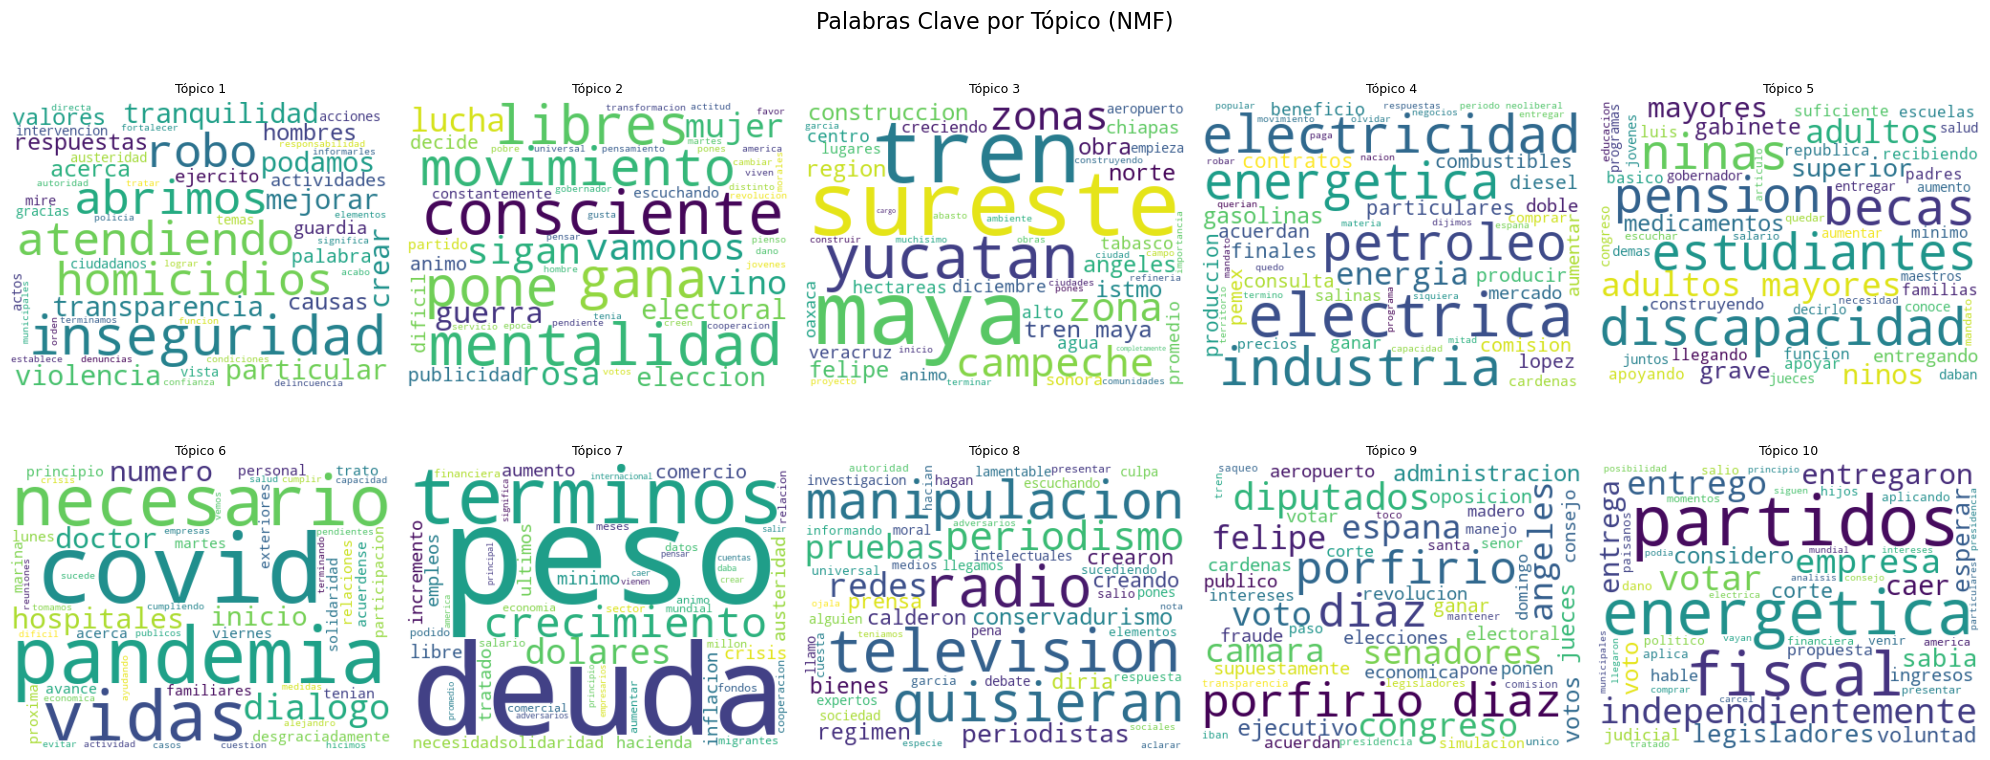

In [37]:
# --- Visualizar los tópicos con WordCloud
filas, columnas = 2, 5
fig, axes = plt.subplots(filas, columnas, figsize=(20, 8))

# Aplanar el array de ejes para facilitar la iteración
axes = axes.flatten()

# Generar WordClouds solo para los 10 tópicos
for i, componente in enumerate(H[:10]):
    pesos = dict(zip(terms, componente))
    wc = WordCloud(width=400, height=300, background_color='white', max_words=50).generate_from_frequencies(pesos)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f'Tópico {i+1}', fontsize=9)
    axes[i].axis('off')

# Ajustar espacios y título general
plt.tight_layout()
plt.suptitle('Palabras Clave por Tópico (NMF)', fontsize=16, y=1.02)
plt.show()

In [38]:
nombre_topicos_nmf = [
    "seguridad y violencia", # 1 
    "fraude electoral", # 2
    "tren maya", # 3
    "reforma energética", # 4
    "programas sociales y pensiones", # 5
    "pandemia", # 6
    "economía", # 7
    "manipulación en medios de comunicación", # 8
    "distribución de recursos", # 9
    "administración pública", # 10
]

In [39]:
# Obtener el tópico dominante para cada documento (conferencia)
topic_assignments = np.argmax(W, axis=1)  # Índice del tópico con mayor score

# Mapear índices a nombres de tópicos
# df_weeks['topico_asignado'] = [nombre_topicos_svd[i] for i in topic_assignments]

df_limpio['topico_asignado_nmf'] = [nombre_topicos_nmf[i] for i in topic_assignments]

# Ver distribución de tópicos
print(df_limpio['topico_asignado_nmf'].value_counts())

topico_asignado_nmf
pandemia                                  38
manipulación en medios de comunicación    36
distribución de recursos                  28
administración pública                    26
tren maya                                 25
seguridad y violencia                     24
reforma energética                        22
fraude electoral                          22
programas sociales y pensiones            20
economía                                  20
Name: count, dtype: int64


## Asignación de tópicos y distribución temática

Una vez generadas las nubes de palabras para cada uno de los 10 componentes latentes, **asignamos manualmente un nombre representativo a cada tópico** de acuerdo con las palabras más relevantes extraídas del modelo NMF.

### Tabla de asignación de nombres a los tópicos extraídos por NMF

| Número de Tópico | Nombre del Tópico                               |
|------------------|------------------------------------------------|
| 1                | seguridad y violencia                           |
| 2                | fraude electoral                               |
| 3                | tren maya                                      |
| 4                | reforma energética                             |
| 5                | programas sociales y pensiones                 |
| 6                | pandemia                                       |
| 7                | economía                                      |
| 8                | manipulación en medios de comunicación         |
| 9                | distribución de recursos                       |
| 10               | administración pública                         |

---

## Asignación de tópicos a los documentos

Luego de obtener la representación de cada documento en el espacio latente de NMF, se asignó a cada semana su **tópico dominante**, es decir, aquel tópico con mayor peso para ese documento. A continuación observamos como se agrupan los topicos usando diferentes modelos de reducción de dimensionalidad.

/Users/lucianoandresjuarezlopez/anaconda3/envs/ciencia_datos_proyecto/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



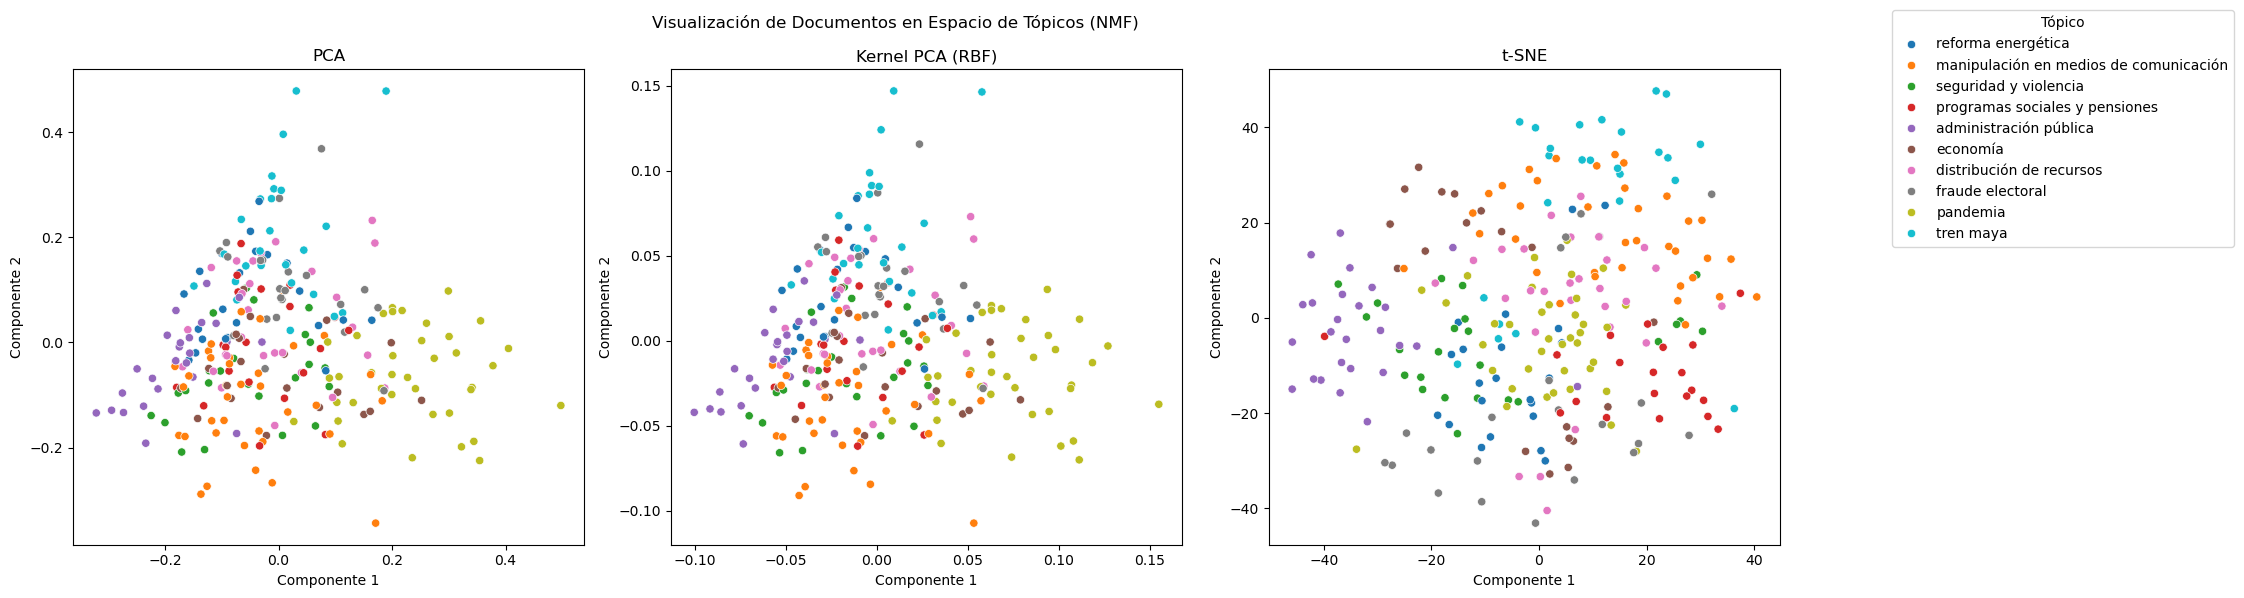

In [40]:
# Normalizar W
W_normalized = W / W.sum(axis=1, keepdims=True)

# --- Reducción de dimensionalidad (usando W_normalized) ---
pca = PCA(n_components=3)
X_pca = pca.fit_transform(W_normalized)

kpca = KernelPCA(n_components=3, kernel='rbf', gamma=0.05)
X_kpca = kpca.fit_transform(W_normalized)

tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(W_normalized)

# --- Visualización conjunta ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PCA
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df_limpio['topico_asignado_nmf'],
    palette='tab10',
    ax=axes[0], legend=False
)
axes[0].set_title('PCA')
axes[0].set_xlabel('Componente 1')
axes[0].set_ylabel('Componente 2')

# Kernel PCA
sns.scatterplot(
    x=X_kpca[:, 0], y=X_kpca[:, 1],
    hue=df_limpio['topico_asignado_nmf'],
    palette='tab10',
    ax=axes[1], legend=False
)
axes[1].set_title('Kernel PCA (RBF)')
axes[1].set_xlabel('Componente 1')
axes[1].set_ylabel('Componente 2')

# t-SNE
scatter = sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=df_limpio['topico_asignado_nmf'],
    palette='tab10',
    ax=axes[2],
    legend=True
)
axes[2].set_title('t-SNE')
axes[2].set_xlabel('Componente 1')
axes[2].set_ylabel('Componente 2')

# Leyenda única
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, title='Tópico', bbox_to_anchor=(1.05, 1), loc='upper left')

axes[2].legend_.remove()

plt.suptitle('Visualización de Documentos en Espacio de Tópicos (NMF)')
plt.tight_layout()
plt.show()

In [41]:
# Crear DataFrames para cada reducción de dimensionalidad
df_pca_3d = pd.DataFrame(X_pca, columns=['x', 'y', 'z'])
df_kpca_3d = pd.DataFrame(X_kpca, columns=['x', 'y', 'z'])
df_tsne_3d = pd.DataFrame(X_tsne, columns=['x', 'y', 'z'])

# Añadir la columna de tópicos asignados para colorear
df_pca_3d['topico'] = df_limpio['topico_asignado_nmf'].values
df_kpca_3d['topico'] = df_limpio['topico_asignado_nmf'].values
df_tsne_3d['topico'] = df_limpio['topico_asignado_nmf'].values

# Función para graficar 3D con Plotly
def graficar_3d(df, titulo):
    fig = px.scatter_3d(
        df,
        x='x', y='y', z='z',
        color='topico',
        title=titulo,
        opacity=0.7,
        labels={'topico': 'Tópico'}
    )
    fig.show()

# Graficar PCA 3D
graficar_3d(df_pca_3d, 'Visualización 3D PCA de Documentos por Tópico')

# Graficar Kernel PCA 3D
graficar_3d(df_kpca_3d, 'Visualización 3D Kernel PCA (RBF) de Documentos por Tópico')

# Graficar t-SNE 3D
graficar_3d(df_tsne_3d, 'Visualización 3D t-SNE de Documentos por Tópico')


### Hallazgos observados en las visualizaciones

Se aplicaron técnicas de reducción de dimensionalidad como **PCA**, **Kernel PCA** y **t-SNE** con el objetivo de visualizar posibles agrupamientos temáticos en los documentos.

Al visualizar los resultados en dos dimensiones, se observa que **t-SNE** ofrece una mejor separación entre los tópicos, permitiendo identificar agrupamientos más definidos. Por otro lado, con **PCA** y **Kernel PCA** también se pueden distinguir algunos grupos, pero en general se presentan solapamientos entre tópcios, por lo que no se distingue claramente la delimitación de los temas.

Al extender la visualización a 3 dimensiones para los tres métodos, se mejora la percepción espacial de los agrupamientos. En este espacio tridimensional, la separación de tópicos resulta más evidente y facilita la identificación visual de los grupos temáticos, aportando una visión más rica y completa de la distribución de los documentos.

### Conclusión sobre el uso de SVD vs NMF para modelado de tópicos

En la práctica, con SVD se observó que **todos los documentos se asignaban mayoritariamente a un mismo tópico dominante**, lo que indica que el modelo puede no capturar bien la diversidad temática real. Al aplicar NMF, se pudo obtener una distribución temática más clara y diversificada, que se refleja en mejores agrupamientos al visualizar con técnicas de reducción dimensional (especialmente con t-SNE). Por lo que se concluye que cuando se busca interpretabilidad y asignaciones claras de documentos a tópicos, NMF suele ser una mejor opción que SVD, ya que genera componentes no negativos y más intuitivos.